Mean Squared Error: 0.00
R² Score: 0.94


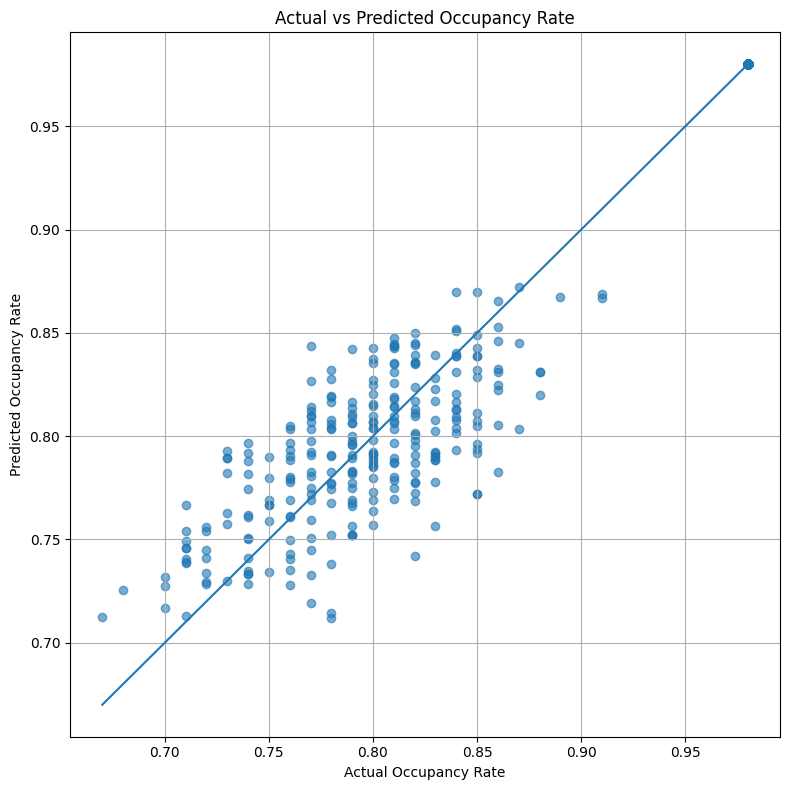

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
hotels = pd.read_csv('hotels_modified.csv')
hotel_amenities = pd.read_csv('hotel_amenities_modified.csv')
city_tourism = pd.read_csv('city_tourism_modified.csv')
econ = pd.read_csv('economic_indicators.csv')
occupancy = pd.read_csv('monthly_occupancy_modified.csv')

# Feature engineering: amenities count per hotel
amen_count = hotel_amenities.groupby('hotel_id')['amenity_id']\
    .nunique().reset_index().rename(columns={'amenity_id': 'amenities_count'})
hotels = hotels.merge(amen_count, on='hotel_id', how='left').fillna({'amenities_count': 0})

# Merge datasets
data = occupancy.merge(
    hotels[['hotel_id', 'star_rating', 'amenities_count', 'city']],
    on='hotel_id'
).merge(
    city_tourism[['city', 'year', 'month', 'tourist_arrivals', 'avg_stay_length', 'event_days']],
    on=['city', 'year', 'month']
)

# Prepare economic indicators
#econ['date'] = pd.to_datetime(econ['date'])
#econ['year'] = econ['date'].dt.year
#econ['month'] = econ['date'].dt.month
econ_feats = econ[['year', 'month', 'inflation_rate', 'unemployment', 'consumer_confidence']]

# Final merge
data = data.merge(econ_feats, on=['year', 'month'])

# Define features and target
features = [
    'star_rating', 'amenities_count', 'tourist_arrivals',
    'avg_stay_length', 'event_days', 'inflation_rate',
    'unemployment', 'consumer_confidence'
]
X = data[features]
y = data['occupancy_rate']

# Display first few rows of features
X.head

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot predicted vs actual
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test, y_pred, alpha=0.6)
lims = [min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))]
ax.plot(lims, lims)
ax.set_xlabel('Actual Occupancy Rate')
ax.set_ylabel('Predicted Occupancy Rate')
ax.set_title('Actual vs Predicted Occupancy Rate')
ax.grid(True)
plt.tight_layout()
plt.show()


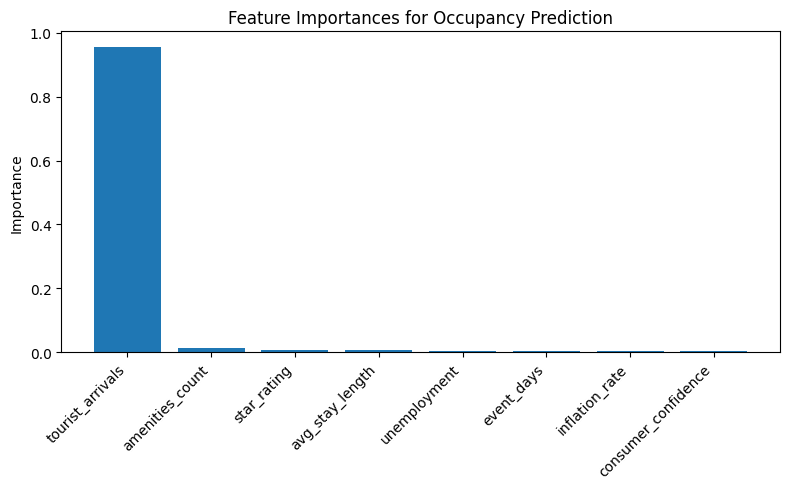

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


# Reload and prepare data
hotels = pd.read_csv('hotels_modified.csv')
hotel_amenities = pd.read_csv('hotel_amenities_modified.csv')
city_tourism = pd.read_csv('city_tourism_modified.csv')
econ = pd.read_csv('economic_indicators.csv')
occupancy = pd.read_csv('monthly_occupancy_modified.csv')

# Amenities count
amen_count = (
    hotel_amenities
    .groupby('hotel_id')['amenity_id']
    .nunique()
    .reset_index()
    .rename(columns={'amenity_id': 'amenities_count'})
)
hotels = hotels.merge(amen_count, on='hotel_id', how='left').fillna({'amenities_count': 0})

# Merge tables
data = (
    occupancy
    .merge(hotels[['hotel_id', 'star_rating', 'amenities_count', 'city']], on='hotel_id')
    .merge(city_tourism[['city', 'year', 'month', 'tourist_arrivals', 'avg_stay_length', 'event_days']],
           on=['city', 'year', 'month'])
)
#econ['date'] = pd.to_datetime(econ['date'])
#econ['year'] = econ['date'].dt.year
#econ['month'] = econ['date'].dt.month
econ_feats = econ[['year', 'month', 'inflation_rate', 'unemployment', 'consumer_confidence']]
data = data.merge(econ_feats, on=['year', 'month'])

# Features and target
features = [
    'star_rating', 'amenities_count', 'tourist_arrivals',
    'avg_stay_length', 'event_days', 'inflation_rate',
    'unemployment', 'consumer_confidence'
]
X = data[features]
y = data['occupancy_rate']

# Train/test split and model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Compute feature importances
importances = model.feature_importances_
feat_imp = (
    pd.Series(importances, index=features)
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'index': 'feature', 0: 'importance'})
)

# Display table to user
feat_imp

# Plot importances
plt.figure(figsize=(8, 5))
plt.bar(feat_imp['feature'], feat_imp['importance'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance')
plt.title('Feature Importances for Occupancy Prediction')
plt.tight_layout()
plt.show()


Correlation matrix:
                 gdp_per_capita  crime_rate  transit_score  avg_arrivals  \
gdp_per_capita             1.00        0.34           0.68         -0.00   
crime_rate                 0.34        1.00           0.78          0.38   
transit_score              0.68        0.78           1.00          0.56   
avg_arrivals              -0.00        0.38           0.56          1.00   
avg_stay_length            0.26        0.04          -0.03         -0.68   

                 avg_stay_length  
gdp_per_capita              0.26  
crime_rate                  0.04  
transit_score              -0.03  
avg_arrivals               -0.68  
avg_stay_length             1.00  


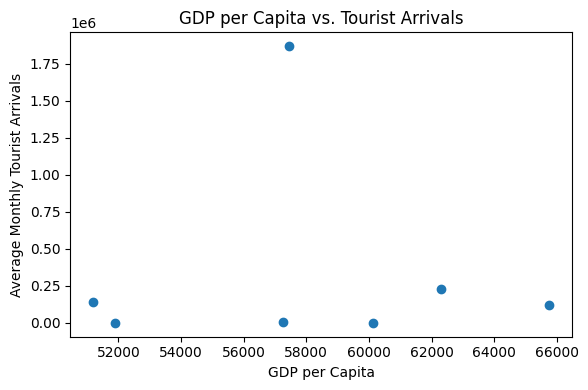

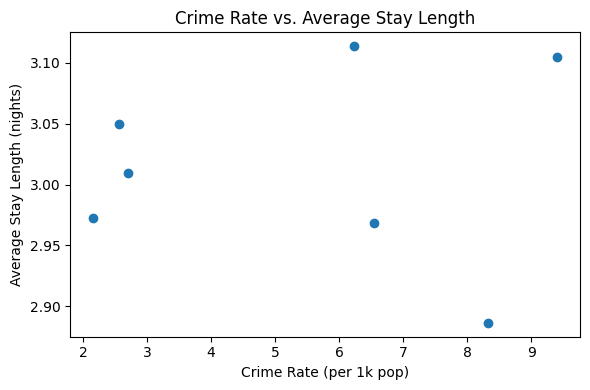

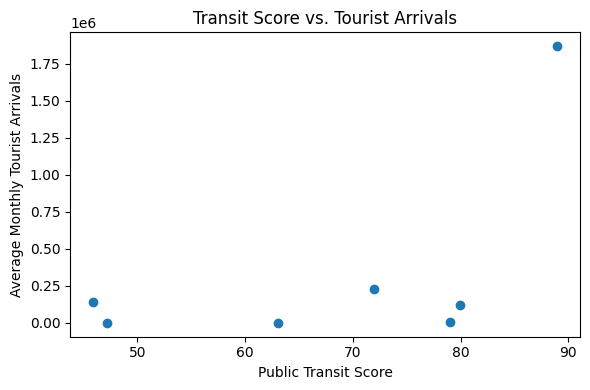

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load your internal tables
cities = pd.read_csv('cities_modified.csv')             # columns: city, province, population, tourism_rank
tourism = pd.read_csv('city_tourism_modified.csv')      # columns: city, month, year, tourist_arrivals, event_days, avg_stay_length

# 2) Load the external socioeconomic dataset
#    expected columns: city, gdp_per_capita (float), crime_rate (per 1k pop), transit_score (0–100)
socio = pd.read_csv('socioeconomic.csv')

# 3) Merge cities ↔ socioeconomic on 'city'
city_meta = pd.merge(cities, socio, on='city', how='inner')

# 4) Aggregate tourism to one metric per city
tourism_agg = (
    tourism
    .groupby('city')
    .agg(
        avg_arrivals     = ('tourist_arrivals', 'mean'),
        avg_stay_length  = ('avg_stay_length',  'mean'),
        total_event_days = ('event_days',       'sum')
    )
    .reset_index()
)

# 5) Merge meta ↔ tourism_agg
df = pd.merge(city_meta, tourism_agg, on='city', how='inner')

# 6) Compute and print correlation matrix
corr_cols = ['gdp_per_capita', 'crime_rate', 'transit_score', 
             'avg_arrivals', 'avg_stay_length']
corr_matrix = df[corr_cols].corr().round(2)
print("Correlation matrix:")
print(corr_matrix)

# 7) Plot GDP per Capita vs. Tourist Arrivals
plt.figure(figsize=(6,4))
plt.scatter(df['gdp_per_capita'], df['avg_arrivals'])
plt.xlabel('GDP per Capita')
plt.ylabel('Average Monthly Tourist Arrivals')
plt.title('GDP per Capita vs. Tourist Arrivals')
plt.tight_layout()
plt.show()

# 8) Plot Crime Rate vs. Average Stay Length
plt.figure(figsize=(6,4))
plt.scatter(df['crime_rate'], df['avg_stay_length'])
plt.xlabel('Crime Rate (per 1k pop)')
plt.ylabel('Average Stay Length (nights)')
plt.title('Crime Rate vs. Average Stay Length')
plt.tight_layout()
plt.show()

# 9) Plot Transit Score vs. Tourist Arrivals
plt.figure(figsize=(6,4))
plt.scatter(df['transit_score'], df['avg_arrivals'])
plt.xlabel('Public Transit Score')
plt.ylabel('Average Monthly Tourist Arrivals')
plt.title('Transit Score vs. Tourist Arrivals')
plt.tight_layout()
plt.show()


Model: avg_arrivals ~ gdp_per_capita
  Coefficient: -0.3389
  Intercept:   356769.0584
  R-squared:   0.0000



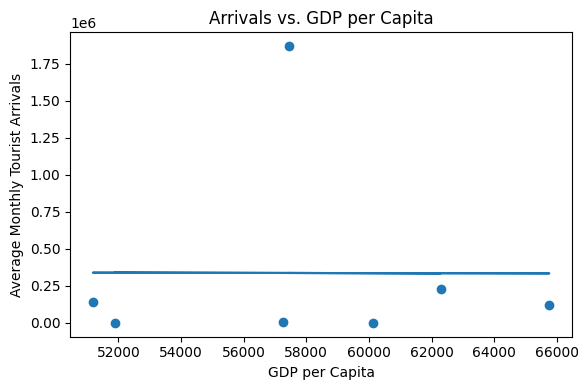

Model: avg_stay_length ~ crime_rate
  Coefficient: 0.0012
  Intercept:   3.0083
  R-squared:   0.0020



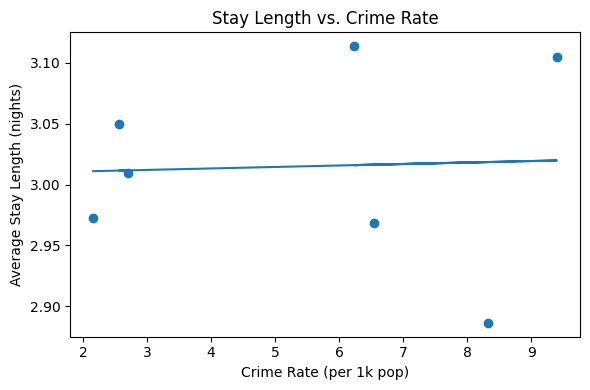

Model: avg_arrivals ~ transit_score
  Coefficient: 23074.3796
  Intercept:   -1232172.3372
  R-squared:   0.3185



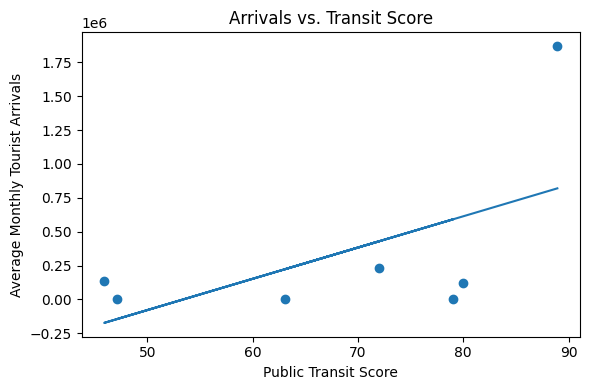

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1) Load data
cities = pd.read_csv('cities_modified.csv')
tourism = pd.read_csv('city_tourism_modified.csv')
socio = pd.read_csv('socioeconomic.csv')

# 2) Merge cities ↔ socioeconomic
city_meta = pd.merge(cities, socio, on='city', how='inner')

# 3) Aggregate tourism metrics
tourism_agg = (
    tourism.groupby('city')
    .agg(
        avg_arrivals=('tourist_arrivals', 'mean'),
        avg_stay_length=('avg_stay_length', 'mean')
    )
    .reset_index()
)

# 4) Final dataset
df = pd.merge(city_meta, tourism_agg, on='city', how='inner')

# Function to fit and plot simple linear regression
def fit_and_plot(x_col, y_col, x_label, y_label, title):
    X = df[[x_col]].values
    y = df[y_col].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    print(f"Model: {y_col} ~ {x_col}")
    print(f"  Coefficient: {model.coef_[0]:.4f}")
    print(f"  Intercept:   {model.intercept_:.4f}")
    print(f"  R-squared:   {r2:.4f}\n")
    
    plt.figure(figsize=(6, 4))
    plt.scatter(df[x_col], df[y_col])
    plt.plot(df[x_col], y_pred)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 5) Fit & plot for each relation
fit_and_plot(
    'gdp_per_capita', 'avg_arrivals',
    'GDP per Capita', 'Average Monthly Tourist Arrivals',
    'Arrivals vs. GDP per Capita'
)

fit_and_plot(
    'crime_rate', 'avg_stay_length',
    'Crime Rate (per 1k pop)', 'Average Stay Length (nights)',
    'Stay Length vs. Crime Rate'
)

fit_and_plot(
    'transit_score', 'avg_arrivals',
    'Public Transit Score', 'Average Monthly Tourist Arrivals',
    'Arrivals vs. Transit Score'
)
